Imports

In [167]:
import matplotlib.pyplot as plt
import random, sys
import numpy as np
from scipy.spatial import Voronoi

In [168]:
# define a bound graph function so we can utilize all of the voronoi points.
# infinite ridge edges use index (-1) for indices of edges points at infinity; bounding makes these points finite
def boundGraph(pset,M):
    return np.append(pset, ([[M,0],[-M,0],[0,M],[0,-M]]), axis=0)

def dist(a,b):
    return np.sqrt((b[1] - a[1])**2 + (b[0] - a[0])**2)

def normalize(vec):
    return vec / magsqrt(vec)

def magsqrt(vec):
    return np.sqrt(vec[0]**2 + vec[1]**2)

# both functions from https://stackoverflow.com/questions/3838329/how-can-i-check-if-two-segments-intersect
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

# R-limit Delaunay code
def point_check(my_vor, p1, p1_idx, p2_idx, r):
    p1_reg = my_vor.point_region[p1_idx]
    p2_reg = my_vor.point_region[p2_idx]

    cn = np.intersect1d(my_vor.regions[p1_reg], my_vor.regions[p2_reg])
    if(cn.size > 0):
        if(cn[0] != -1 and cn[1] != -1):
            v1 = my_vor.vertices[cn[0]]
            v2 = my_vor.vertices[cn[1]]
            return (dist(v1,p1) <= r or dist(v2,p1) <= r)
        return False

def rlimit(my_vor, r, a):
    edges = list()
    P     = my_vor.points
    V     = my_vor.vertices
    rp    = my_vor.ridge_points
    rv    = my_vor.ridge_vertices

    for i in range(rp.shape[0]):
        u = P[rp[i]]
        v = V[rv[i]]
        
        # if looking at bound vertex, they have positions (+-M,0) and (0,+-M)
        # np.all returns true if there are no values for false in our array
        # this will only be true for our boundary points, filters them out
        if(not np.all(u)):
            continue

        u_idx = rp[i][0]
        uN_idx = rp[i][1]

        if (intersect(u[0],u[1],v[0],v[1]) and (dist(u[0],u[1]) <= 2*r) and (dist(u[0],u[1]) >= 2*a)):
            edges.append(rp[i])
            continue
        else:
            if(point_check(my_vor, u[0], u_idx, uN_idx, r) == True):
                edges.append(rp[i])
                continue
    return np.array(edges)

def gradPsi(qi,qj,shell,r):
    # break qi into ix, iy
    ix = qi[0]
    iy = qi[1]
    # break qj into jx, jy
    jx = qj[0]
    jy = qj[1]

    # compare x and y to find + or - for grad x and grad y
    # if ix > jx, flip it and if iy > jy, flip it
    mx = -1 if ix > jx else 1
    my = -1 if iy > jy else 1
    # partial derivatives of the potential function with respect to qi moving, in x and y respectively
    my_grad_x = -mx*(2 * np.abs(jx - ix) * ( ( 1 / ((jx-ix)*(jx-ix) - 4*shell*shell)**2 ) + ( 1 / (r*r - (jx-ix)*(jx-ix))**2 ) ))
    my_grad_y = -my*(2 * np.abs(jy - iy) * ( ( 1 / ((jy-iy)*(jy-iy) - 4*shell*shell)**2 ) + ( 1 / (r*r - (jy-iy)*(jy-iy))**2 ) ))

    return my_grad_x, my_grad_y

class boids:
    def __init__(self, points, edges, r, eps, shell, a_scale, b_scale, bound, *args):
        self.adjList = {}
        self.r = r
        self.eps = eps
        self.shell = shell
        self.points = np.copy(points)
        self.edges = np.copy(edges)
        self.a_scale = a_scale
        self.b_scale = b_scale
        self.bound = bound

        if(args):
            rng = np.random.default_rng(args)
            self.seed = args
        else:
            # https://stackoverflow.com/questions/5012560/how-to-query-seed-used-by-random-random
            seed = random.randrange(sys.maxsize)
            rng = np.random.default_rng(seed)
            self.seed = seed

        # fill out self.adjList based off init points and edges for each point
        for i in range(points.shape[0]):
            # neighbor finding code
            neighbors = np.append(edges[:,1][np.where(edges[:,0] == i)], 
                                  edges[:,0][np.where(edges[:,1] == i)])

            temp_n = list()
            for j in range(neighbors.shape[0]):
                this_dist = dist(points[i], points[neighbors[j]])
                if ((this_dist > (2*self.shell + self.eps)) and (this_dist < (self.r - self.eps))):
                    temp_n.append(neighbors[j])

            self.adjList[i] = {0 : np.zeros((3,2)), 1 : neighbors, 2 : np.array(temp_n)}
            self.adjList[i][0][0] = points[i]
            self.adjList[i][0][1] = (rng.random() * 0.2 - 0.1, rng.random() * 0.2 - 0.1)   # init random velocities


    # calculate forces
    def step(self):
        points_next = np.zeros((self.points.shape[0],2))
        for i in range(len(self.adjList)):
            alpha_i = np.zeros(2)
            beta_i = np.zeros(2)
            for j in range(len(self.adjList[i][2])):
                # find idx of each neighboring point in points list from class
                j_idx = self.adjList[i][2][j]

                pi = self.adjList[i][0][1]
                pj = self.adjList[j_idx][0][1]
                alpha_i -= (pi - pj)                             # alignment term

                qi = self.adjList[i][0][0]
                qj = self.adjList[j_idx][0][0]
                # vectorize beta in dir of qij
                # split x and y
                beta_i -= (gradPsi(qi,qj,self.shell,self.r))     # cohesion and seperation terms
        
            # normalize alpha and beta if theyre too big so they have the same influence
            if (magsqrt(alpha_i) > (1 / self.a_scale)):
                alpha_i = normalize(alpha_i) / self.a_scale
                
            if (magsqrt(beta_i) > (1 / self.b_scale)):
                beta_i = normalize(beta_i) / self.b_scale

            ui = alpha_i + beta_i
            if (len(self.adjList[i][2]) > 0):
                ui /= len(self.adjList[i][2])

            self.adjList[i][0][2] = ui                         # ui = alpha_i + beta_i
            self.adjList[i][0][0] += self.adjList[i][0][1]     # qi += pi
            self.adjList[i][0][1] += self.adjList[i][0][2]     # pi += ui

            # also update point in points array for class to current point positions
            points_next[i] = self.adjList[i][0][0]

        self.points = points_next
    
    
    # step updates the adjList, so we need to update both the neighbors and the E' connections
    # update neighbor is called after step, so we want to take the voronoi, update points and 
    # edges of the boids class, then update neighbor connections
    def update_neighbors(self):
        temp_edges = rlimit(Voronoi(boundGraph(self.points, self.bound)), self.r/2, self.shell)      # get points, take voronoi, take r limit
        self.edges = temp_edges

        # update neighbors
        for i in range(self.points.shape[0]):
            # new neighbors
            neighbors = np.append(self.edges[:,1][np.where(self.edges[:,0] == i)],
                                  self.edges[:,0][np.where(self.edges[:,1] == i)])

            n_diff = np.setdiff1d(neighbors, self.adjList[i][2])               # in neighbors but not E'(t)
            e_diff = np.setdiff1d(self.adjList[i][2], neighbors)               # in E'(t) but not neighbors at this step

            # check over current neighbors in E but not E'
            for j in range(n_diff.size):
                temp_dist = dist(self.points[i], self.points[n_diff[j]])
                if ((temp_dist < (self.r - self.eps)) and (temp_dist > (2*self.shell + self.eps))):
                    self.adjList[i][2] = np.append(self.adjList[i][2], (n_diff[j]))
            
            # check over edges in E' but not E
            self.adjList[i][2] = np.setdiff1d(self.adjList[i][2], e_diff)

            self.adjList[i][1] = neighbors

Using the Model: 1st, put your desired variables in the cell below. 2nd, generate a random initial set of points. 3rd, initialize n_edges, 4th, start plotting!

In [169]:
### INIT ###
num_agents = 50
shell = 0.25
r = 2.5
eps = r - np.sqrt(r*r - 4*shell*shell)
bound = 100

print('shell =', shell, ', r =', r, ', eps =', eps, ', bound =', bound)

# set scale for alpha and beta
alpha_scale = 2
beta_scale  = 128

# seed for rng; controls init positions and init velocities
my_seed = 8547024940712817374

shell = 0.25 , r = 2.5 , eps = 0.05051025721682212 , bound = 100


Make a point set, reload until you find one you're happy with. The rng won't change until you remove my_seed from default_rng()

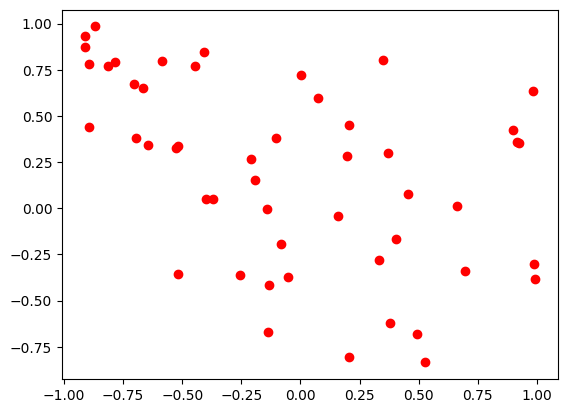

In [170]:
rng = np.random.default_rng(my_seed) # can take my_seed out for random points
n_points = rng.random((num_agents,2)) * 2 - 1

plt.plot(n_points[:,0],n_points[:,1], 'ro')
plt.show()

Make sure to execute this code!!!!

In [171]:
# load in our edges from the r-limit Del
n_edges = rlimit(Voronoi(boundGraph(n_points, bound)),(r/2), shell)

We can now use our model to graph our agents as they evolve in time

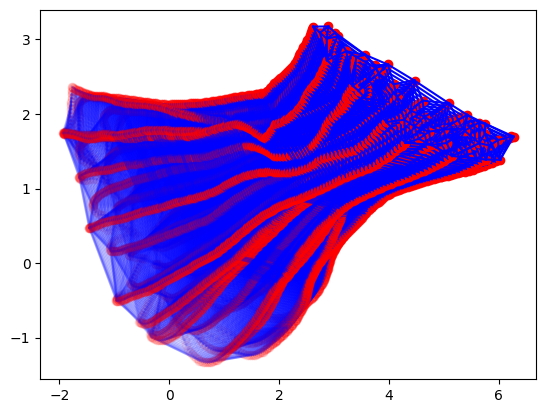

executed 150 steps


In [172]:
# reminder: take my_seed out and the function will generate and print a seed for you
birds = boids(n_points, n_edges, r, 
              eps, shell, alpha_scale, 
              beta_scale, bound, my_seed)

n_steps = 150
buff = 5
for n in range(buff,n_steps+buff):
    birds.step()
    birds.update_neighbors()

    # keeping these lines indented will give you the timelapse as the birds move
    # remove the tab before these two lines to just plot the final configuration
    # of birds after n_steps. so have all three plt. functions where plt.show is
    plt.plot(birds.points[:,0], birds.points[:,1], 'ro', alpha=(n/(n_steps+buff)))
    plt.plot(birds.points[:,0][birds.edges.T], 
                birds.points[:,1][birds.edges.T], '-b', alpha=(n/(n_steps+buff)))
plt.show()
    
print('executed', n_steps, 'steps')

We can also plot every x steps, allowing us a little more visual clarity into what is going on. Here we define a stepx function we will use soon.

In [109]:
def stepx(bird, x):
    for i in range(x):
        bird.step()
        bird.update_neighbors()
    buff = 1
    plt.plot(bird.points[:,0], bird.points[:,1], 'ro')
    plt.plot(bird.points[:,0][bird.edges.T], bird.points[:,1][bird.edges.T], '-b')

Reminder, if you leave the seed section blank in the boids() init function, it will generate one for you that is saved in boids.seed. If you see a flocking sim you really like, save the seed!

In [16]:
print(birds.seed)

8547024940712817374


Using these seeds, we can recreate the same plot and show different time scales by resetting our birds with the same initial set of points and velocity seed.

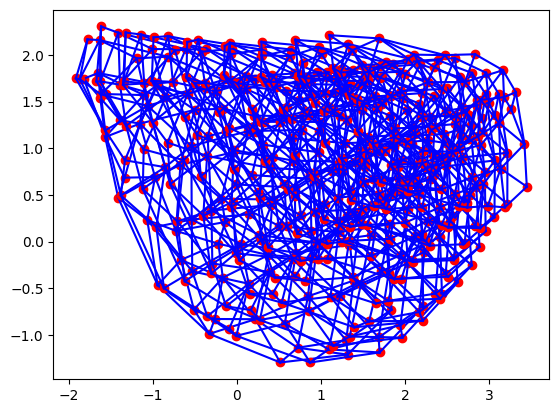

t = 100


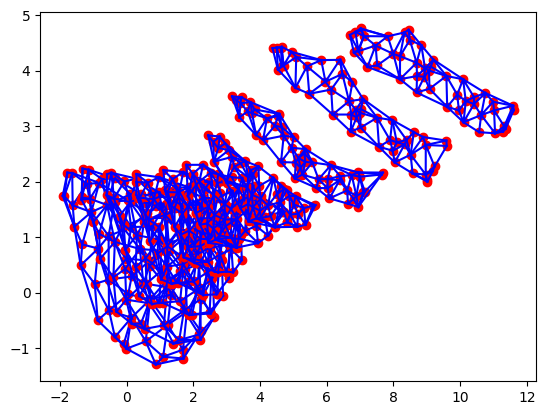

t = 200


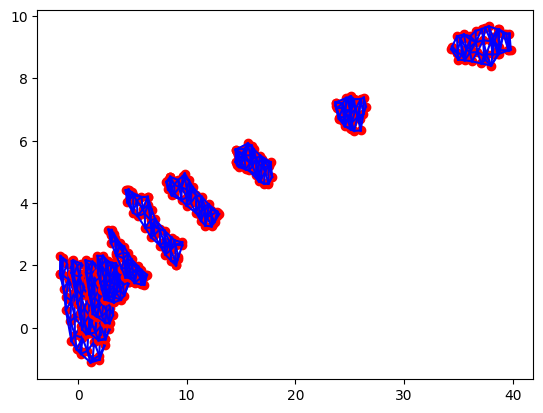

t = 300


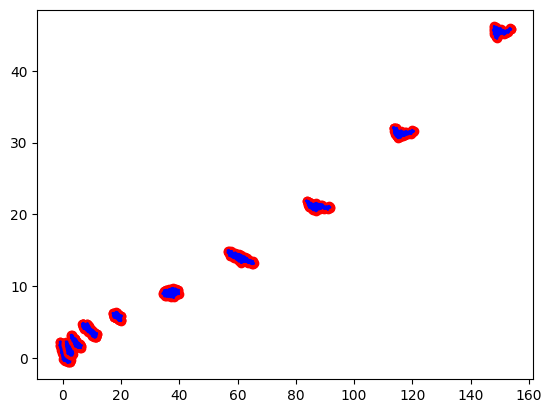

t = 500


In [84]:
loopx = 10

#
birds = boids(n_points, n_edges, r, 
              eps, shell, alpha_scale, 
              beta_scale, bound, my_seed)

x = 10
for i in range(loopx):
    stepx(birds, x)
plt.show()
print('t =', x*loopx)
#
birds = boids(n_points, n_edges, r, 
              eps, shell, alpha_scale, 
              beta_scale, bound, my_seed)

x = 20
for i in range(loopx):
    stepx(birds, x)
plt.show()
print('t =', x*loopx)
#
birds = boids(n_points, n_edges, r, 
              eps, shell, alpha_scale, 
              beta_scale, bound, my_seed)

x = 30
for i in range(loopx):
    stepx(birds, x)
plt.show()
print('t =', x*loopx)
#
birds = boids(n_points, n_edges, r, 
              eps, shell, alpha_scale, 
              beta_scale, bound, my_seed)

x = 50
for i in range(loopx):
    stepx(birds, x)
plt.show()
print('t =', x*loopx)

With specific setups:

In [81]:
def linear(num):
    points = np.arange(0,num,1)
    points = np.vstack((points - num/2,(rng.random(num)/1000))).T

    plt.plot(points[:,0],points[:,1], 'ro')
    plt.ylim([-1,1])
    plt.show()

    edges = rlimit(Voronoi(boundGraph(points, bound)),(r/2), shell)
    return points, edges

def my_random(num, width):
    points = np.random.default_rng().random((num,2)) * width - (width/2)
    edges = rlimit(Voronoi(boundGraph(points, bound)),(r/2), shell)
    return points, edges

def circle():
    return

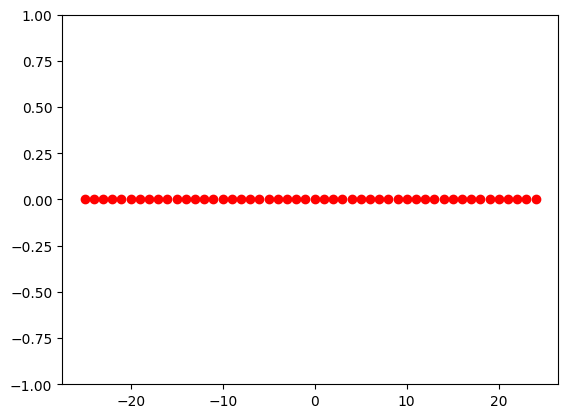

executed  250 steps


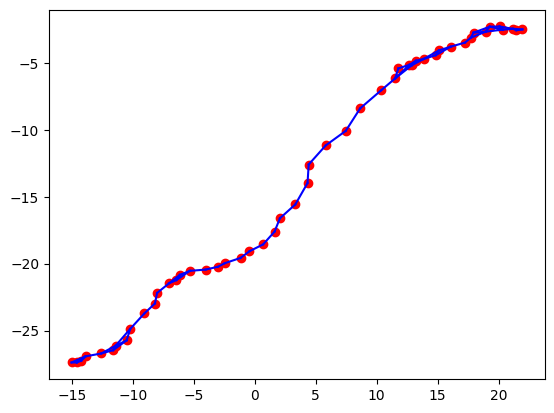

In [110]:
# answer = input("What do you want")
# n_points, n_edges = my_random(num_agents, 5)
my_points, my_edges = linear(num_agents)

mybirds = boids(my_points, my_edges, r, 
                eps, shell, 2, 256, bound)

n_steps = 250
buff = 5
for n in range(buff,n_steps+buff):
    mybirds.step()
    mybirds.update_neighbors()

plt.plot(mybirds.points[:,0], mybirds.points[:,1], 'ro', alpha=(n/(n_steps+buff)))
plt.plot(mybirds.points[:,0][mybirds.edges.T], 
         mybirds.points[:,1][mybirds.edges.T], '-b', alpha=(n/(n_steps+buff)))
    
print('executed ', n_steps, 'steps')

# need stronger beta than 32 for long term cohesion

We can also use the same seed to test what variations to alpha_scale and beta_scale do

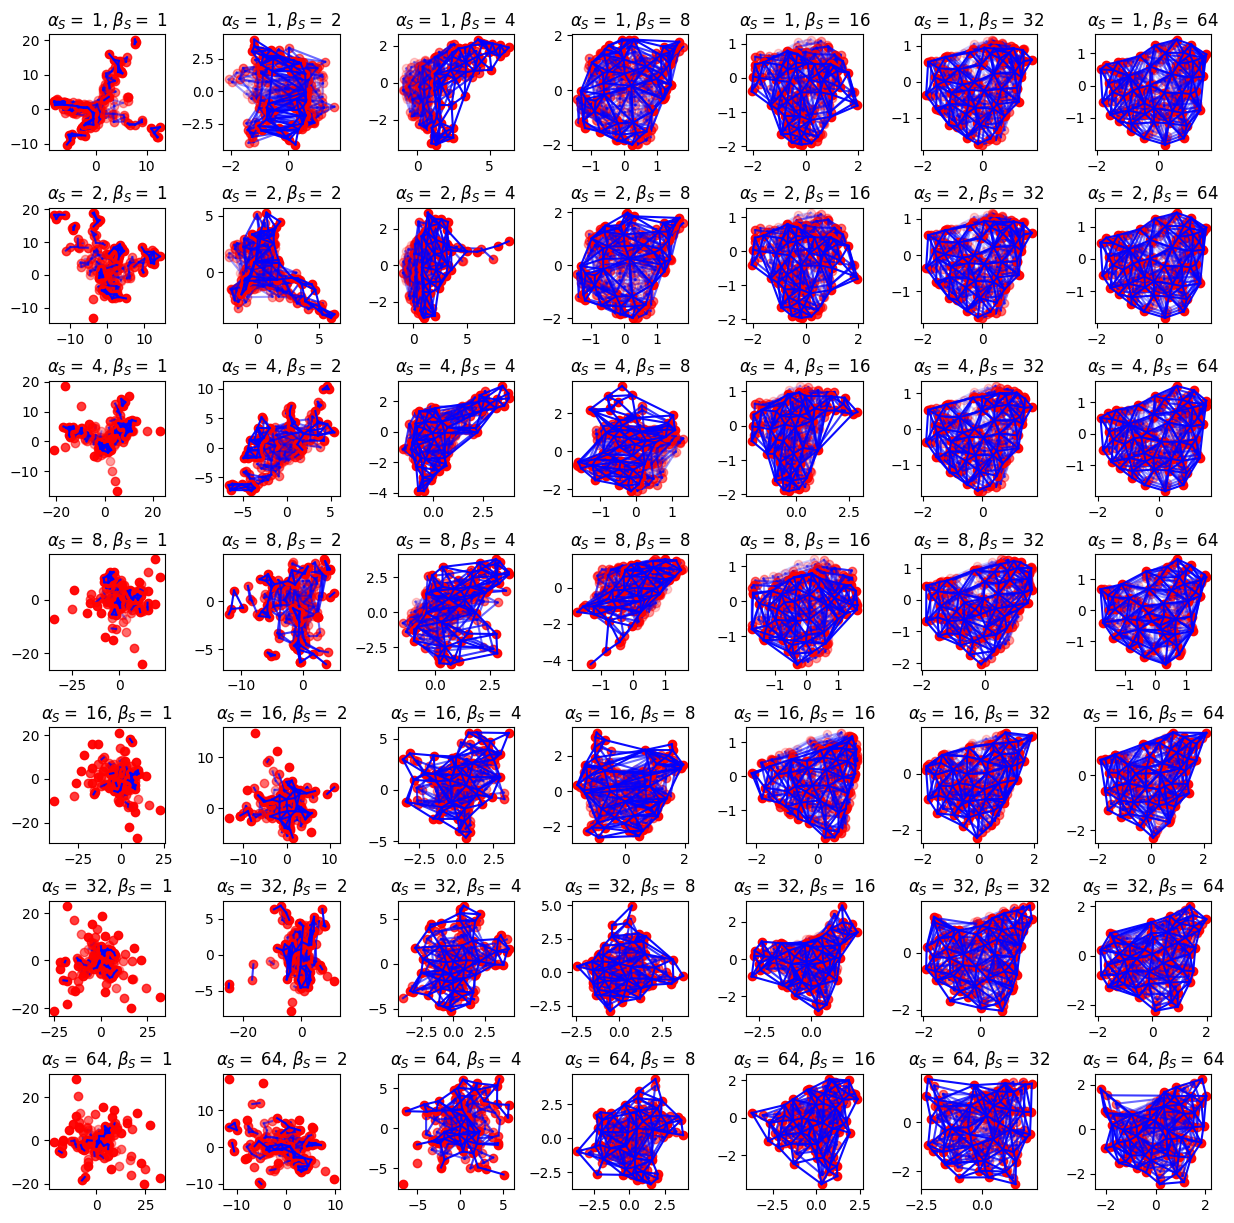

In [36]:
scalesA = np.array((1,2,4,8,16,32,64))
scalesB = np.copy(scalesA)

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(scalesA.size, scalesB.size, hspace = 0.5, wspace = 0.5)
# axs = gs.subplots(sharex='col', sharey='row')
axs = gs.subplots()

for x in range (scalesA.size):
    for y in range (scalesB.size):
        birds = boids(n_points, n_edges, r, eps, shell, scalesA[x], scalesB[y], bound, my_seed)

        n_steps = 25
        buff = 1
        for n in range(buff,n_steps+buff):
            birds.step()
            birds.update_neighbors()
            if(n % 5 == 0):
                axs[x,y].plot(birds.points[:,0], birds.points[:,1], 'ro', alpha=(n/(n_steps+buff)))
                axs[x,y].plot(birds.points[:,0][birds.edges.T], birds.points[:,1][birds.edges.T], '-b', alpha=(n/(n_steps+buff)))
                axs[x,y].set_title(r'$\alpha_S =$ ' + str(scalesA[x]) + r', $\beta_S =$ ' + str(scalesB[y]))

# fig.tight_layout()
plt.show()

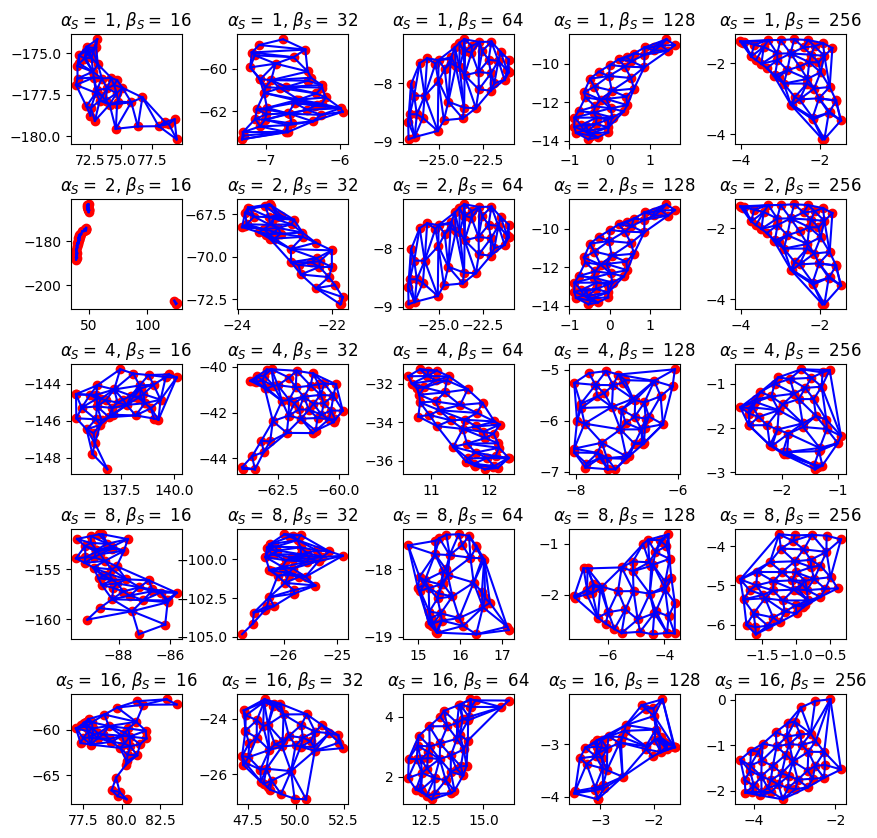

In [17]:
scalesA = np.array((1,2,4,8,16))
scalesB = np.array((16,32,64,128,256))

fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(scalesA.size, scalesB.size, hspace = 0.5, wspace = 0.5)
# axs = gs.subplots(sharex='col', sharey='row')
axs = gs.subplots()

for x in range (scalesA.size):
    for y in range (scalesB.size):
        birds = boids(n_points, n_edges, r, eps, shell, scalesA[x], scalesB[y], bound, my_seed)

        n_steps = 300
        buff = 1
        for n in range(buff,n_steps+buff):
            birds.step()
            birds.update_neighbors()
            
        axs[x,y].plot(birds.points[:,0], birds.points[:,1], 'ro', alpha=(n/(n_steps+buff)))
        axs[x,y].plot(birds.points[:,0][birds.edges.T], birds.points[:,1][birds.edges.T], '-b', alpha=(n/(n_steps+buff)))
        axs[x,y].set_title(r'$\alpha_S =$ ' + str(scalesA[x]) + r', $\beta_S =$ ' + str(scalesB[y]))

# fig.tight_layout()
plt.show()

Animation uses the FuncAnimation from matplotlib. I haven't gotten edges to work in the animation function (same plotting func as the step by step methods above, not sure what's going wrong yet)

In [95]:
from matplotlib.animation import FuncAnimation, PillowWriter
from time import localtime, strftime

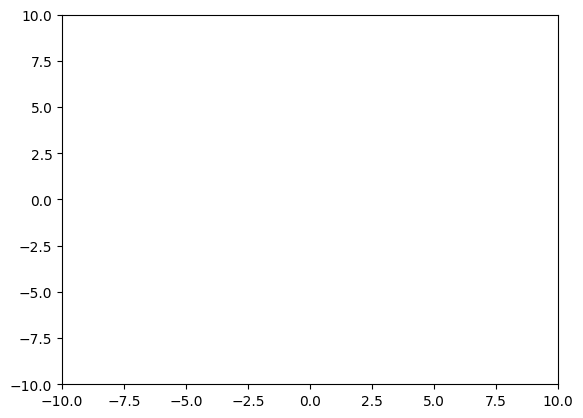

In [98]:
animbirds = boids(n_points, n_edges, r, 
              eps, shell, alpha_scale, 
              beta_scale, bound, my_seed)

fig = plt.figure()  
width = 10
axis = plt.axes(xlim =(-width, width),
                ylim =(-width, width))

agents, = axis.plot([], [], 'ro')
line, = axis.plot([], [], '-b')

def init():
    agents.set_data([], [])
    line.set_data([], [])
    return agents, line,
   
def animate(i):
    animbirds.step()
    animbirds.update_neighbors()

    t_points = animbirds.points
    agents.set_data(t_points[:,0], t_points[:,1])
    
    return agents, line,

# interval!!!!
anim = FuncAnimation(fig, animate, init_func = init, 
                     frames = 300, interval = 100)

time_str = strftime("%Y%m%d%H%M%S", localtime())
file_name = "boids_" + time_str + ".gif"

anim.save(filename=file_name, dpi=200, writer=PillowWriter(fps=30))

# anim method https://www.geeksforgeeks.org/using-matplotlib-for-animations/

Runtime Measurements

In [112]:
import time

In [166]:
test_num = 250
test_bound = 1000
test_points = rng.random((test_num,2)) * 2 - 1


print('func runtimes for ', test_num, ' agents')
runtimes = list()

start = time.time()
test_edges = rlimit(Voronoi(boundGraph(test_points, test_bound)),(r/2), shell)
end = time.time()
print(len(runtimes), ': rlimit(Voronoi()), ', (end - start)*1000, 'ms')
runtimes.append((end-start))

start = time.time()
test_birds = boids(test_points, test_edges, r, eps, shell, alpha_scale, beta_scale, bound, my_seed)
end = time.time()
print(len(runtimes), ': init(), ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])


start = time.time()
test_birds.step()
end = time.time()
print(len(runtimes), ': step(), ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])

start = time.time()
test_birds.update_neighbors()
end = time.time()
print(len(runtimes), ': update_neighbors(), ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])


start = time.time()
test_birds.step()
end = time.time()
print(len(runtimes), ': step() #2, ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])

start = time.time()
test_birds.update_neighbors()
end = time.time()
print(len(runtimes), ': update_neighbors() #2, ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])


start = time.time()
test_birds.step()
end = time.time()
print(len(runtimes), ': step() #3, ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])

start = time.time()
test_birds.update_neighbors()
end = time.time()
print(len(runtimes), ': update_neighbors() #3, ', (end - start)*1000, 'ms')
runtimes.append((end-start))

print('number of points and edges :', test_birds.points.shape[0], '|', test_birds.edges.shape[0])

print('max runtime,', np.max(runtimes) * 1000, 'ms, at idx', np.where(runtimes == np.max(runtimes))[0])

func runtimes for  250  agents
0 : rlimit(Voronoi()),  24.85799789428711 ms
1 : init(),  8.645057678222656 ms
number of points and edges : 250 | 720
2 : step(),  0.0 ms
number of points and edges : 250 | 720
3 : update_neighbors(),  28.29575538635254 ms
number of points and edges : 250 | 720
4 : step() #2,  0.0 ms
number of points and edges : 250 | 720
5 : update_neighbors() #2,  43.84922981262207 ms
number of points and edges : 250 | 726
6 : step() #3,  2.4559497833251953 ms
number of points and edges : 250 | 726
7 : update_neighbors() #3,  33.81657600402832 ms
number of points and edges : 250 | 730
max runtime, 43.84922981262207 ms, at idx [5]
